1. Load the packages

In [ ]:
from torch.utils.data import Dataset,DataLoader,TensorDataset
from sklearn.datasets import fetch_openml
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plot
import torch
import torch.nn as nn
from torch.autograd.function import Function
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from  torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

2. Define the function used to load MNIST and USPS data splits



You need to download[ MNIST-USPS data splits](https://github.com/samotiian/CCSA) generated in [1] to run this code. Then: 


2.1. If you run the code on Colab, you will need to put these splits in the corresponding folder of your [Google Drive](https://drive.google.com/drive/u/0/my-drive).


2.2. If you run the code locally, you will need to put these splits in the corresponding folder of your device.



[1] Motiian, S., Piccirilli, M., Adjeroh, D. A., & Doretto, G. (2017). Unified deep supervised domain adaptation and generalization. In Proceedings of the IEEE international conference on computer vision (pp. 5715-5725).

In [ ]:
# Mount the Google drive, please ignore this cell if you run the code locally.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# The path where you put the data.
initial_path='/content/drive/MyDrive/MINIST domain adaptation/CCSA-master/row_data/'

In [ ]:
# The function used to load the data, refered to:
##
#Motiian, S., Piccirilli, M., Adjeroh, D. A., & Doretto, G. (2017). 
#Unified deep supervised domain adaptation and generalization. 
#In Proceedings of the IEEE international conference on computer vision (pp. 5715-5725).
##


def read_data(domain_adaptation_task,repetition,sample_per_class):
    UM  = domain_adaptation_task
    cc  = repetition
    SpC = sample_per_class
    if UM != 'MNIST_to_USPS':
        if UM != 'USPS_to_MNIST':
            raise Exception('domain_adaptation_task should be either MNIST_to_USPS or USPS_to_MNIST')
    if cc <0 or cc>10:
        raise Exception('number of repetition should be between 0 and 9.')
    if SpC <1 or SpC>7:
            raise Exception('number of sample_per_class should be between 1 and 7.')
    X_train_target=np.load(initial_path + UM + '_X_train_target_repetition_' + str(cc) + '_sample_per_class_' + str(SpC) + '.npy')
    y_train_target=np.load(initial_path + UM + '_y_train_target_repetition_' + str(cc) + '_sample_per_class_' + str(SpC) + '.npy')
    X_train_source=np.load(initial_path + UM + '_X_train_source_repetition_' + str(cc) + '_sample_per_class_' + str(SpC) + '.npy')
    y_train_source=np.load(initial_path + UM + '_y_train_source_repetition_' + str(cc) + '_sample_per_class_' + str(SpC) + '.npy')
    X_test = np.load(initial_path + UM + '_X_test_target_repetition_' + str(cc) + '_sample_per_class_' + str(SpC)+'.npy')
    y_test = np.load(initial_path + UM + '_y_test_target_repetition_' + str(cc) + '_sample_per_class_' + str(SpC)+'.npy')
    print("Target X : ", X_train_target.shape, " Y : ", y_train_target.shape)
    print("Source X : ", X_train_source.shape, " Y : ", y_train_source.shape)
    print("Test X : ", X_test.shape, " Test_Y : ", y_test.shape)
    return X_train_target,y_train_target,X_train_source,y_train_source,X_test,y_test


Target X :  (30, 16, 16)  Y :  (30,)
Source X :  (1800, 16, 16)  Y :  (1800,)
Test X :  (2000, 16, 16)  Test_Y :  (2000,)


## **We only use the source data in the training set**

In [ ]:
# USPS_to_MNIST
# MNIST_to_USPS
repetition=2
sample_per_class=3
X_train_target,y_train_target,X_train_source,y_train_source,X_test,y_test=read_data('USPS_to_MNIST',repetition,sample_per_class)
x_train=X_train_source
y_train=y_train_source
x_train=torch.from_numpy(x_train).reshape(-1,1,16,16)
y_train=torch.from_numpy(y_train)
x_test=torch.from_numpy(X_test).reshape(-1,1,16,16)
y_test=torch.from_numpy(y_test)
x_train=x_train.float()
x_test=x_test.float()
y_train=y_train.long()
y_test=y_test.long()
# form the dataset
train_dataset=TensorDataset(x_train,y_train)
val_dataset=TensorDataset(x_test,y_test)


3. Define LetNet++ for MNIST-USPS

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1_1 = nn.Conv2d(1, 32, kernel_size=5, padding=2)
        self.prelu1_1 = nn.PReLU()
        self.conv1_2 = nn.Conv2d(32, 32, kernel_size=5, padding=2)
        self.prelu1_2 = nn.PReLU()
        self.conv2_1 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.prelu2_1 = nn.PReLU()
        self.conv2_2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
        self.prelu2_2 = nn.PReLU()
        self.conv3_1 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
        self.prelu3_1 = nn.PReLU()
        self.conv3_2 = nn.Conv2d(128, 128, kernel_size=5, padding=2)
        self.prelu3_2 = nn.PReLU()
        self.preluip1 = nn.PReLU()
        self.ip1 = nn.Linear(128*2*2, 84)
        self.ip2 = nn.Linear(84, 10, bias=False)


    def forward(self, x):
        x = self.prelu1_1(self.conv1_1(x))
        x = self.prelu1_2(self.conv1_2(x))
        x = F.max_pool2d(x,2)
        x = self.prelu2_1(self.conv2_1(x))
        x = self.prelu2_2(self.conv2_2(x))
        x = F.max_pool2d(x,2)
        x = self.prelu3_1(self.conv3_1(x))
        x = self.prelu3_2(self.conv3_2(x))
        x = F.max_pool2d(x,2)
        x = x.view(-1, 128*2*2)
        ip1 = self.preluip1(self.ip1(x))
        ip2 = self.ip2(ip1)
        return ip1,F.log_softmax(ip2, dim=1)

4. Define the training in one epoch

In [ ]:
#deine the training within 1 epoch
def train(epoch):
  print ("Training... Epoch = %d" % epoch)
  ip1_loader = []
  idx_loader = []
  #Training in each epoch#
  for data, target in train_loader:
    data, target = data.to(device), target.to(device)
    ip1, pred = model(data)
    loss = nllloss(pred, target)
    optimizer4nn.zero_grad()
    loss.backward()
    optimizer4nn.step()

    ip1_loader.append(ip1)
    idx_loader.append((target))
  test_out = model(x_test.to(device))[1]
  pred_y = torch.max(test_out.cpu(), 1)[1].data.numpy()
  accuracy = float((pred_y == y_test.data.numpy()).astype(int).sum()) / float(y_test.size(0))
  return model



5. Train the model

In [ ]:
#Activate GPU
use_cuda = torch.cuda.is_available() and True
device = torch.device("cuda" if use_cuda else "cpu")
train_loader= DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=2)
model = Net().to(device)
nllloss = nn.CrossEntropyLoss().to(device) #CrossEntropyLoss = log_softmax + NLLLoss
optimizer4nn = optim.Adam(model.parameters(),lr=0.0005,weight_decay=0)
sheduler = lr_scheduler.StepLR(optimizer4nn,20,gamma=0.8)
# optimzer4center
for epoch in range(100):
    sheduler.step()
    train(epoch+1)
print("Training finishes...............")

Training... Epoch = 1


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Training... Epoch = 2
Training... Epoch = 3
Training... Epoch = 4
Training... Epoch = 5
Training... Epoch = 6
Training... Epoch = 7
Training... Epoch = 8
Training... Epoch = 9
Training... Epoch = 10
Training... Epoch = 11
Training... Epoch = 12
Training... Epoch = 13
Training... Epoch = 14
Training... Epoch = 15
Training... Epoch = 16
Training... Epoch = 17
Training... Epoch = 18
Training... Epoch = 19
Training... Epoch = 20
Training... Epoch = 21
Training... Epoch = 22
Training... Epoch = 23
Training... Epoch = 24
Training... Epoch = 25
Training... Epoch = 26
Training... Epoch = 27
Training... Epoch = 28
Training... Epoch = 29
Training... Epoch = 30
Training... Epoch = 31
Training... Epoch = 32
Training... Epoch = 33
Training... Epoch = 34
Training... Epoch = 35
Training... Epoch = 36
Training... Epoch = 37
Training... Epoch = 38
Training... Epoch = 39
Training... Epoch = 40
Training... Epoch = 41
Training... Epoch = 42
Training... Epoch = 43
Training... Epoch = 44
Training... Epoch =

6. Visualization function

In [ ]:

def visualize(srcfeature,srclabel,tarfeature, tarlabel):
    fea=np.vstack((srcfeature,tarfeature))
    feature = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(fea)
    src=feature[:len(srcfeature)]
    tar=feature[len(srcfeature):]

    plt.ion()
    c = ['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff',
         '#ff00ff', '#990000', '#999900', '#009900', '#000000']    
    plt.clf()
    for i in range(10):
        plt.scatter(src[srclabel == i, 0], src[srclabel == i, 1], marker='.', c=c[i])
    for i in range(10):
        plt.scatter(tar[tarlabel == i, 0], tar[tarlabel == i, 1], marker='^',c=c[i],edgecolor='black', linewidth=0.2,alpha=0.5)
    plt.savefig('/'+"figure.jpg", format='jpg', dpi=1200)
    plt.draw()


7. Perform another selection of data and do the visualization

Target X :  (10, 16, 16)  Y :  (10,)
Source X :  (2000, 16, 16)  Y :  (2000,)
Test X :  (1800, 16, 16)  Test_Y :  (1800,)


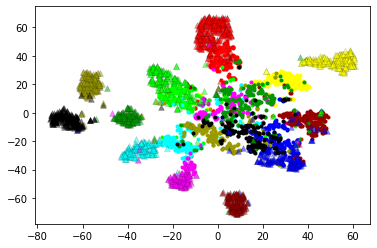

In [ ]:
# Another selection of data
X_train_target,y_train_target,X_train_source,y_train_source,X_test,y_test=read_data('MNIST_to_USPS',3,1)
source_x=X_train_source
source_y=y_train_source
target_x=X_test
target_y=y_test

source_x=torch.from_numpy(source_x).reshape(-1,1,16,16)
target_x=torch.from_numpy(target_x).reshape(-1,1,16,16)

source_x=source_x.float()
target_x=target_x.float()
source_feature= model(source_x.to(device))[0].data.cpu().numpy()
target_feature= model(target_x.to(device))[0].data.cpu().numpy()

# Visualization
visualize(source_feature,source_y,target_feature,target_y)